In [1]:
!nvidia-smi

Sat Oct 21 14:53:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0              17W / 136W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary

In [3]:
from transformations import test_transforms #train_transforms

In [4]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [5]:
# ALbumentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.HorizontalFlip(always_apply=False,p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, mask_value=(0.4914, 0.4822, 0.4465), always_apply=False,p=0.5,),
    A.CoarseDropout( max_holes= 2,max_height = 8,max_width = 8,min_holes= 2,min_height = 8,min_width= 8,mask_fill_value = (0.4914, 0.4822, 0.4465),always_apply = False, p= 0.7),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616),p=1),
    ToTensorV2(),
])

atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)

In [6]:
# # GET Train Loader

# train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False)
# test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

# cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
# train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


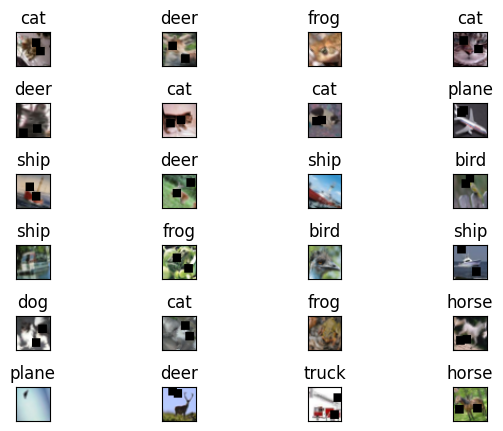

In [7]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

In [8]:
class Net9(nn.Module):
        def __init__(self,sequeeze_channels:list,dp_rate=0.1):
            super(Net9,self).__init__()
            self.dp_rate=dp_rate

            self.C11 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[0] ,out_channels=sequeeze_channels[0],groups=sequeeze_channels[0], kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[0], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(
                        #     in_channels=sequeeze_channels[0],
                        #     out_channels=sequeeze_channels[2],
                        #     kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )

            self.C12 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        
                        # nn.Conv2d(
                        #     in_channels=sequeeze_channels[2],
                        #     out_channels=sequeeze_channels[2],
                        #     kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.C13 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[2],
                        #           out_channels=sequeeze_channels[2],
                        #           kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.T11 = nn.Sequential(
                nn.Conv2d(in_channels=sequeeze_channels[2],out_channels=sequeeze_channels[1],kernel_size=1,stride=1,bias=False,dilation=1)
            )


            self.C21  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[1],groups=sequeeze_channels[1],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C22 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C23 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T21 = nn.Sequential(nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[3],kernel_size=1,stride=1,bias=False,dilation=2))

            
            self.C31  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[3],groups=sequeeze_channels[3],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C32  =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C33 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T31 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[6],kernel_size=1,stride=1,bias=False,dilation=3)
            )           
            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            
        def forward(self,x):
            x = self.C11(x)
            x = x+self.C12(x)            
            x = self.C13(x)
            x = self.T11(x)
            
            x = self.C21(x)
            x = x+self.C22(x)
            x = self.C23(x)
            x = self.T21(x)
            
            
            x = self.C31(x)
            x = x+self.C32(x)
            x = self.C33(x)
            x = self.T31(x)

            x = self.gap(x)
            return F.log_softmax(x.view(-1,10), dim=1)

model9 = Net9(sequeeze_channels=[3,8,16,24,32,40,10],dp_rate=0.15)
summary(model9,(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net9                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 3, 32, 32]            27
│    └─Conv2d: 2-2                       [1, 16, 32, 32]           48
│    └─ReLU: 2-3                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-4                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-5                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 16, 32, 32]           144
│    └─Conv2d: 2-7                       [1, 16, 32, 32]           256
│    └─ReLU: 2-8                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-9                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-10                   [1, 16, 32, 32]           --
├─Sequential:

In [9]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model9.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model9, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model9, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model9.state_dict(),f='./bmodels/model9_modified_aug.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.83 | Batch = 97 | Accuracy = 22.28: 100%|███| 98/98 [00:36<00:00,  2.70it/s]


Test set: Average loss: 0.0035, Accuracy: 3124/10000 (31.24%)


EPOCH = 2 | LR = 0.1 | Loss = 1.78 | Batch = 97 | Accuracy = 28.97: 100%|███| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0034, Accuracy: 3514/10000 (35.14%)


EPOCH = 3 | LR = 0.1 | Loss = 1.74 | Batch = 97 | Accuracy = 31.69: 100%|███| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0033, Accuracy: 3852/10000 (38.52%)


EPOCH = 4 | LR = 0.1 | Loss = 1.65 | Batch = 97 | Accuracy = 34.26: 100%|███| 98/98 [00:41<00:00,  2.39it/s]


Test set: Average loss: 0.0031, Accuracy: 4079/10000 (40.79%)


EPOCH = 5 | LR = 0.1 | Loss = 1.74 | Batch = 97 | Accuracy = 35.89: 100%|███| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0030, Accuracy: 4568/10000 (45.68%)


EPOCH = 6 | LR = 0.1 | Loss = 1.57 | Batch = 97 | Accuracy = 37.47: 100%|███| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0030, Accuracy: 4324/10000 (43.24%)


EPOCH = 7 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 38.37: 100%|███| 98/98 [00:41<00:00,  2.39it/s]


Test set: Average loss: 0.0029, Accuracy: 4542/10000 (45.42%)


EPOCH = 8 | LR = 0.1 | Loss = 1.65 | Batch = 97 | Accuracy = 40.09: 100%|███| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0027, Accuracy: 4936/10000 (49.36%)


EPOCH = 9 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 41.33: 100%|███| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0027, Accuracy: 4995/10000 (49.95%)


EPOCH = 10 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 42.40: 100%|██| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0026, Accuracy: 5148/10000 (51.48%)


EPOCH = 11 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 42.89: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0026, Accuracy: 5220/10000 (52.20%)


EPOCH = 12 | LR = 0.1 | Loss = 1.66 | Batch = 97 | Accuracy = 43.75: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0026, Accuracy: 5229/10000 (52.29%)


EPOCH = 13 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 44.16: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0026, Accuracy: 5263/10000 (52.63%)


EPOCH = 14 | LR = 0.1 | Loss = 1.60 | Batch = 97 | Accuracy = 44.46: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0026, Accuracy: 5285/10000 (52.85%)


EPOCH = 15 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 44.93: 100%|██| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0025, Accuracy: 5373/10000 (53.73%)


EPOCH = 16 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 45.61: 100%|██| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0025, Accuracy: 5518/10000 (55.18%)


EPOCH = 17 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 46.16: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0025, Accuracy: 5400/10000 (54.00%)


EPOCH = 18 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 46.15: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0024, Accuracy: 5684/10000 (56.84%)


EPOCH = 19 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 46.80: 100%|██| 98/98 [00:35<00:00,  2.79it/s]


Test set: Average loss: 0.0025, Accuracy: 5466/10000 (54.66%)


EPOCH = 20 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 46.78: 100%|██| 98/98 [00:35<00:00,  2.80it/s]


Test set: Average loss: 0.0024, Accuracy: 5603/10000 (56.03%)


EPOCH = 21 | LR = 0.1 | Loss = 1.43 | Batch = 97 | Accuracy = 47.07: 100%|██| 98/98 [00:35<00:00,  2.80it/s]


Test set: Average loss: 0.0024, Accuracy: 5695/10000 (56.95%)


EPOCH = 22 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 47.56: 100%|██| 98/98 [00:34<00:00,  2.82it/s]


Test set: Average loss: 0.0024, Accuracy: 5704/10000 (57.04%)


EPOCH = 23 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 47.58: 100%|██| 98/98 [00:34<00:00,  2.81it/s]


Test set: Average loss: 0.0024, Accuracy: 5699/10000 (56.99%)


EPOCH = 24 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 48.03: 100%|██| 98/98 [00:35<00:00,  2.77it/s]


Test set: Average loss: 0.0024, Accuracy: 5728/10000 (57.28%)


EPOCH = 25 | LR = 0.1 | Loss = 1.57 | Batch = 97 | Accuracy = 48.15: 100%|██| 98/98 [00:38<00:00,  2.55it/s]


Test set: Average loss: 0.0023, Accuracy: 5784/10000 (57.84%)


EPOCH = 26 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 48.46: 100%|██| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0022, Accuracy: 5924/10000 (59.24%)


EPOCH = 27 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 48.83: 100%|██| 98/98 [00:37<00:00,  2.64it/s]


Test set: Average loss: 0.0023, Accuracy: 5828/10000 (58.28%)


EPOCH = 28 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 48.98: 100%|██| 98/98 [00:35<00:00,  2.77it/s]


Test set: Average loss: 0.0023, Accuracy: 5871/10000 (58.71%)


EPOCH = 29 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 48.91: 100%|██| 98/98 [00:36<00:00,  2.72it/s]


Test set: Average loss: 0.0023, Accuracy: 5851/10000 (58.51%)


EPOCH = 30 | LR = 0.1 | Loss = 1.31 | Batch = 97 | Accuracy = 49.11: 100%|██| 98/98 [00:36<00:00,  2.71it/s]


Test set: Average loss: 0.0022, Accuracy: 5977/10000 (59.77%)


EPOCH = 31 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 48.96: 100%|██| 98/98 [00:35<00:00,  2.78it/s]


Test set: Average loss: 0.0023, Accuracy: 5844/10000 (58.44%)


EPOCH = 32 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 49.55: 100%|██| 98/98 [00:35<00:00,  2.77it/s]


Test set: Average loss: 0.0022, Accuracy: 5956/10000 (59.56%)


EPOCH = 33 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 49.38: 100%|██| 98/98 [00:35<00:00,  2.72it/s]


Test set: Average loss: 0.0023, Accuracy: 5777/10000 (57.77%)


EPOCH = 34 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 49.53: 100%|██| 98/98 [00:35<00:00,  2.77it/s]


Test set: Average loss: 0.0022, Accuracy: 6006/10000 (60.06%)


EPOCH = 35 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 49.59: 100%|██| 98/98 [00:34<00:00,  2.83it/s]


Test set: Average loss: 0.0023, Accuracy: 5913/10000 (59.13%)


EPOCH = 36 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 49.63: 100%|██| 98/98 [00:35<00:00,  2.79it/s]


Test set: Average loss: 0.0022, Accuracy: 5961/10000 (59.61%)


EPOCH = 37 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 50.23: 100%|██| 98/98 [00:34<00:00,  2.81it/s]


Test set: Average loss: 0.0022, Accuracy: 5922/10000 (59.22%)


EPOCH = 38 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 49.95: 100%|██| 98/98 [00:34<00:00,  2.84it/s]


Test set: Average loss: 0.0022, Accuracy: 6017/10000 (60.17%)


EPOCH = 39 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 50.25: 100%|██| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0022, Accuracy: 5908/10000 (59.08%)


EPOCH = 40 | LR = 0.1 | Loss = 1.43 | Batch = 97 | Accuracy = 50.14: 100%|██| 98/98 [00:34<00:00,  2.83it/s]


Test set: Average loss: 0.0023, Accuracy: 5866/10000 (58.66%)


EPOCH = 41 | LR = 0.010000000000000002 | Loss = 1.39 | Batch = 97 | Accuracy = 51.13: 100%|█| 98/98 [00:34<0


Test set: Average loss: 0.0021, Accuracy: 6165/10000 (61.65%)


EPOCH = 42 | LR = 0.010000000000000002 | Loss = 1.29 | Batch = 97 | Accuracy = 51.58: 100%|█| 98/98 [00:36<0


Test set: Average loss: 0.0021, Accuracy: 6140/10000 (61.40%)


EPOCH = 43 | LR = 0.010000000000000002 | Loss = 1.38 | Batch = 97 | Accuracy = 51.62: 100%|█| 98/98 [00:34<0


Test set: Average loss: 0.0021, Accuracy: 6162/10000 (61.62%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 1.39 | Batch = 97 | Accuracy = 51.42: 100%|█| 98/98 [00:34<0


Test set: Average loss: 0.0021, Accuracy: 6190/10000 (61.90%)


EPOCH = 45 | LR = 0.010000000000000002 | Loss = 1.43 | Batch = 97 | Accuracy = 51.61: 100%|█| 98/98 [00:34<0


Test set: Average loss: 0.0021, Accuracy: 6199/10000 (61.99%)


EPOCH = 46 | LR = 0.010000000000000002 | Loss = 1.34 | Batch = 97 | Accuracy = 51.93: 100%|█| 98/98 [00:34<0


Test set: Average loss: 0.0021, Accuracy: 6211/10000 (62.11%)


EPOCH = 47 | LR = 0.010000000000000002 | Loss = 1.26 | Batch = 97 | Accuracy = 51.92: 100%|█| 98/98 [00:34<0


Test set: Average loss: 0.0021, Accuracy: 6201/10000 (62.01%)


EPOCH = 48 | LR = 0.010000000000000002 | Loss = 1.35 | Batch = 97 | Accuracy = 51.88: 100%|█| 98/98 [00:34<0


Test set: Average loss: 0.0021, Accuracy: 6182/10000 (61.82%)


EPOCH = 49 | LR = 0.010000000000000002 | Loss = 1.38 | Batch = 97 | Accuracy = 52.18: 100%|█| 98/98 [00:35<0


Test set: Average loss: 0.0021, Accuracy: 6215/10000 (62.15%)


EPOCH = 50 | LR = 0.0010000000000000002 | Loss = 1.38 | Batch = 97 | Accuracy = 52.04: 100%|█| 98/98 [00:34<


Test set: Average loss: 0.0021, Accuracy: 6203/10000 (62.03%)


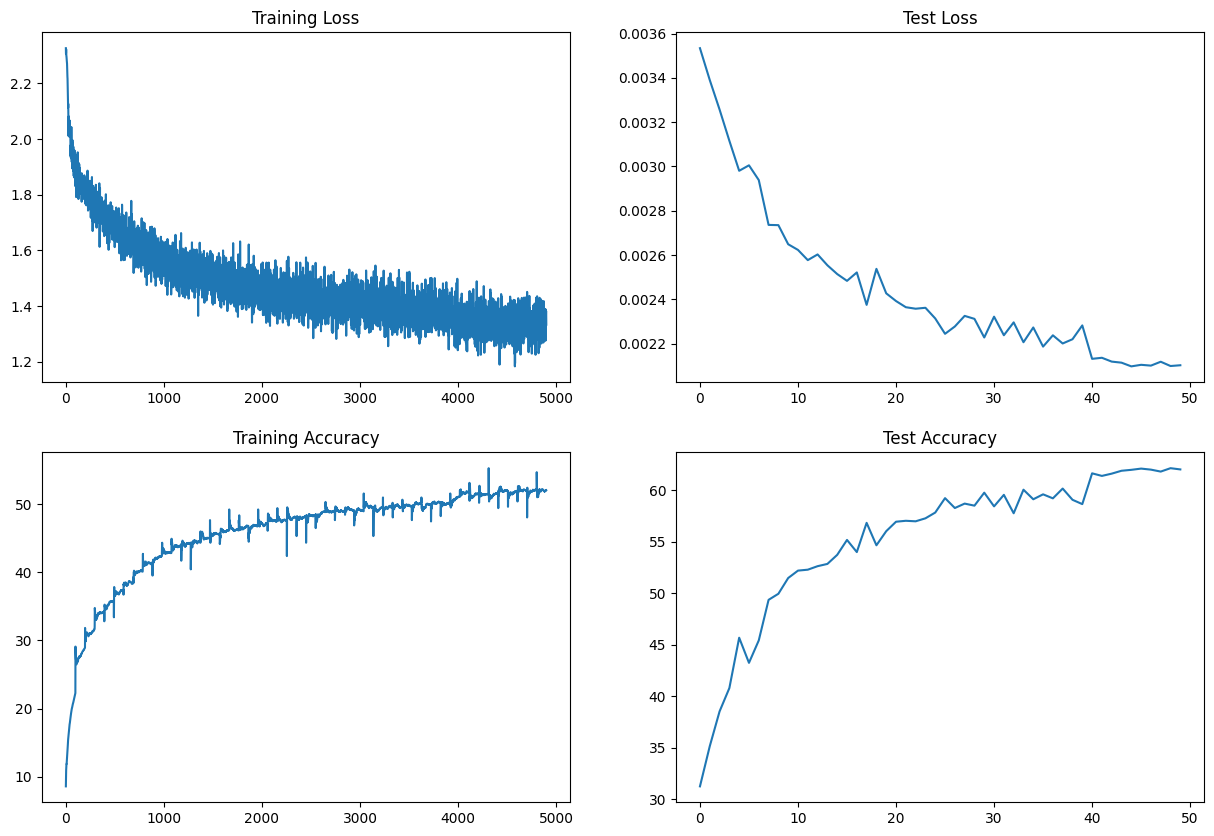

In [10]:

plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# OLD CODE

In [11]:
# We used this Squeeze-Expand Network before
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.dp_rate = 0.2

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=24,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans1 = TransBlock(32,24,p=0.1)
        self.conv2 = nn.Sequential(
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans2 = TransBlock(64,32,p=0.1)
        self.conv3 = nn.Sequential(
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=128,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans3 = TransBlock(128,64,p=0.1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=1,bias=False,)
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(128,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [12]:
simple_model = Net1().to(device)
summary(simple_model,(1,3,32,32))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, ConvLayer: 2, Sequential: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Dropout2d: 4, ConvLayer: 2, Sequential: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Dropout2d: 4, ConvLayer: 2, Sequential: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Dropout2d: 4]

In [ ]:
prev_test_loss = float('inf')

optimizer = optim.SGD(simple_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(simple_model, simple_train_loader, optimizer, criterion, device)
tester = Tester(simple_model, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/simple_model_with_mp_rf44.pth')
    scheduler.step(test_loss)


In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model-1 with Augmentation

In [ ]:
prev_test_loss = float('inf')
simple_model = Net1().to(device)
optimizer = optim.SGD(simple_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(simple_model, train_loader, optimizer, criterion, device)
tester = Tester(simple_model, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/simple_model_with_mp_rf44_aug.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model-2

**Objective**
- remove MP
- use strided instead
- rest same as previous model

**Results**
-
-

In [ ]:
# We used this Squeeze-Expand Network before
class Net2(nn.Module):
    def __init__(self,dp:int):
        super(Net2,self).__init__()
        self.dp_rate = dp

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=24,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=32,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans1 = TransBlock(32,24)
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=24,kernel_size=1,bias=False)
        )
        self.conv2 = nn.Sequential(
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=64,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans2 = TransBlock(64,32)
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=1,bias=False)
        )
        
        self.conv3 = nn.Sequential(
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=128,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans3 = TransBlock(128,64)
        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1,bias=False)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=1,bias=False,)
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(128,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [ ]:
model2_removed_mp = Net2(0.2).to(device)
# summary(model2_removed_mp,(3,32,32))

In [ ]:
prev_test_loss = float('inf')

optimizer = optim.SGD(model2_removed_mp.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model2_removed_mp, train_loader, optimizer, criterion, device)
tester = Tester(model2_removed_mp, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/model1_without_mp.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model-2 with AUG

In [ ]:
prev_test_loss = float('inf')
model2_removed_mp = Net2(0.2).to(device)
optimizer = optim.SGD(model2_removed_mp.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model2_removed_mp, simple_train_loader, optimizer, criterion, device)
tester = Tester(model2_removed_mp, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/model1_without_mp.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model

## normal model ( no conditions apply)

## shrink model  (200k params)

## remove maxpool but 3 conv

## dialated kernels

## depth-wise kernel

## all depth-wise kernel

## apply albumentation